<a href="https://colab.research.google.com/github/aksh-ay06/BRFSS/blob/main/BRFSS2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can State-Level Industrial Pollution Improve Prediction of Self-Reported Cancer Prevalence?

**Data sources**
- **BRFSS 2023** (Behavioral Risk Factor Surveillance System) — 433,323 adults, complex survey design with stratification, clustering (PSUs), and survey weights (`_LLCPWT`).
- **EPA P2 Mapping Data** — 69,416 facility-level pollution records aggregated to state-level exposure metrics (TRI releases, GHG emissions, NEI criteria air pollutants, RCRA hazardous waste, DMR water pollution).

**Approach**
1. Design-aware weighted EDA using `samplics`
2. Merge state-aggregated EPA pollution features into BRFSS respondent data
3. Survey-weighted logistic regression (`samplics.SurveyGLM`) for inference with design-correct standard errors
4. XGBoost for prediction, comparing baseline (demographics only) vs. pollution-augmented models
5. SHAP-based interpretation

## 1 Setup & Configuration

In [61]:
from pathlib import Path
import os, warnings, random
import numpy as np
import pandas as pd
from pandas import NA
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    average_precision_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score,
)
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap

from samplics.categorical.tabulation import Tabulation
from samplics.regression import SurveyGLM
from samplics.utils.types import PopParam, ModelType, SinglePSUEst

SEED = 42
N_JOBS = -1
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

sns.set_theme(context="notebook", style="whitegrid", palette="colorblind")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2 Data Loading

BRFSS uses a complex survey design:
- **`_STSTR`**: Combined stratum (state + sub-stratum) for variance estimation
- **`_PSU`**: Primary Sampling Unit — respondents within the same PSU are correlated
- **`_LLCPWT`**: Final survey weight reflecting probability of selection and non-response adjustments

In [62]:
IS_COLAB = False
try:
    import google.colab
    IS_COLAB = True
except Exception:
    pass

if IS_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    DATA_DIR = Path("/content/drive/MyDrive/BRFSS/2023")
else:
    DATA_DIR = Path("data")

BRFSS_PATH = DATA_DIR / "BRFSS2023.csv"
EPA_PATH   = DATA_DIR / "P2_Mapping_Data.xlsx"

for p in [BRFSS_PATH, EPA_PATH]:
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p.resolve()}")

# Use parquet cache for speed
PARQUET_PATH = BRFSS_PATH.with_suffix(".parquet")
if PARQUET_PATH.exists():
    df_raw = pd.read_parquet(PARQUET_PATH)
else:
    df_raw = pd.read_csv(BRFSS_PATH, low_memory=False)
    df_raw.to_parquet(PARQUET_PATH, index=False)

print(f"BRFSS: {len(df_raw):,} rows x {df_raw.shape[1]} cols")

BRFSS: 433,323 rows x 350 cols


## 3 Feature Selection & Recoding

In [63]:
# Keep survey design variables + analysis features
selected_columns = [
    "_STATE", "_STSTR", "_PSU", "_LLCPWT",
    "CHCOCNC1", "MARITAL", "DEAF", "BLIND", "DECIDE",
    "DIFFWALK", "DIFFDRES", "DIFFALON", "LSATISFY", "EMTSUPRT",
    "SDHBILLS", "SDHUTILS", "SDHTRNSP", "SDHSTRE1",
    "_METSTAT", "_URBSTAT", "_PHYS14D", "_MENT14D", "_HLTHPL1",
    "_TOTINDA", "_MICHD", "_ASTHMS1", "_DRDXAR2", "_RACEPRV",
    "_SEX", "_AGE_G", "HTIN4", "WTKG3", "_BMI5CAT",
    "_RFBMI5", "_CHLDCNT", "_EDUCAG", "_INCOMG1", "_RFSMOK3",
    "_CURECI2", "LCSNUMCG", "_RFBING6", "_DRNKWK2", "_RFDRHV8",
]
missing = [c for c in selected_columns if c not in df_raw.columns]
if missing:
    raise KeyError(f"Columns not found: {missing}")

df = df_raw[selected_columns].copy()
print(f"Selected {df.shape[1]} columns, {len(df):,} rows")

Selected 43 columns, 433,323 rows


In [64]:
# --- Value mappings (BRFSS codebook) ---

STATE_FIPS = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
    27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana",
    31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
    35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota",
    39: "Ohio", 40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania",
    44: "Rhode Island", 45: "South Carolina", 46: "South Dakota",
    47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
    53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming",
    66: "Guam", 72: "Puerto Rico", 78: "Virgin Islands",
}

YESNO_MAP  = {1: "Yes", 2: "No", 7: NA, 9: NA}

variable_mappings = {
    "CHCOCNC1": YESNO_MAP,
    "MARITAL":  {1: "Married", 2: "Divorced", 3: "Widowed", 4: "Separated",
                 5: "Never married", 6: "Unmarried couple", 9: NA},
    "DEAF": YESNO_MAP, "BLIND": YESNO_MAP, "DECIDE": YESNO_MAP,
    "DIFFWALK": YESNO_MAP, "DIFFDRES": YESNO_MAP, "DIFFALON": YESNO_MAP,
    "SDHBILLS": YESNO_MAP, "SDHUTILS": YESNO_MAP, "SDHTRNSP": YESNO_MAP,
    "_METSTAT": {1: "Metropolitan", 2: "Non-metropolitan", 9: NA},
    "_URBSTAT": {1: "Urban", 2: "Rural", 9: NA},
    "_HLTHPL1": {1: "Insured", 2: "Uninsured", 9: NA},
    "_TOTINDA": {1: "Active", 2: "Inactive", 9: NA},
    "_MICHD":   {1: "MI or CHD", 2: "No MI/CHD"},
    "_DRDXAR2": {1: "Arthritis", 2: "No arthritis"},
    "_RACEPRV": {1: "White", 2: "Black", 3: "AI/AN", 4: "Asian",
                 5: "NH/PI", 6: "Other", 7: "Multiracial", 8: "Hispanic"},
    "_SEX":     {1: "Male", 2: "Female", 7: NA, 9: NA},
    "_RFSMOK3": {1: "No", 2: "Yes", 9: NA},
    "_CURECI2": {1: "Not using", 2: "Current user", 9: NA},
    "_RFBMI5":  {1: "No", 2: "Yes", 9: NA},
    "_RFDRHV8": {1: "No", 2: "Yes", 9: NA},
    "_RFBING6": {1: "No", 2: "Yes", 9: NA},
    "_CHLDCNT": {1: "None", 2: "One", 3: "Two", 4: "Three",
                 5: "Four", 6: "Five+", 9: NA},
}

ordinal_definitions = {
    "LSATISFY": (["Very satisfied", "Satisfied", "Dissatisfied", "Very dissatisfied"],
                  {1: "Very satisfied", 2: "Satisfied", 3: "Dissatisfied", 4: "Very dissatisfied"}),
    "EMTSUPRT": (["Always", "Usually", "Sometimes", "Never"],
                  {1: "Always", 2: "Usually", 3: "Sometimes", 4: "Never"}),
    "SDHSTRE1": (["Always", "Usually", "Sometimes", "Never"],
                  {1: "Always", 2: "Usually", 3: "Sometimes", 4: "Never"}),
    "_ASTHMS1": (["Current", "Former", "Never"],
                  {1: "Current", 2: "Former", 3: "Never"}),
    "_AGE_G":   (["18-24", "25-34", "35-44", "45-54", "55-64", "65+"],
                  {1: "18-24", 2: "25-34", 3: "35-44", 4: "45-54", 5: "55-64", 6: "65+"}),
    "_EDUCAG":  (["No HS", "HS Grad", "Some College", "College Grad"],
                  {1: "No HS", 2: "HS Grad", 3: "Some College", 4: "College Grad"}),
    "_INCOMG1": (["<15k", "15-25k", "25-35k", "35-50k", "50-75k", "75k+"],
                  {1: "<15k", 2: "15-25k", 3: "25-35k", 4: "35-50k", 5: "50-75k", 6: "75k+"}),
    "_BMI5CAT": (["Underweight", "Normal", "Overweight", "Obese"],
                  {1: "Underweight", 2: "Normal", 3: "Overweight", 4: "Obese"}),
}

# Helper
def map_codes(s, mapping):
    return pd.to_numeric(s, errors="coerce").astype("Int64").map(mapping).astype("category")

# Map state FIPS -> name (keep numeric FIPS separately for merging)
df["state_name"] = map_codes(df["_STATE"], STATE_FIPS)

# Map nominal variables
for col, mapping in variable_mappings.items():
    if col in df.columns:
        df[col] = map_codes(df[col], mapping)

# Bin unhealthy-days variables
day_cats = ["0 days", "1-13 days", "14+ days"]
day_bins = [-np.inf, 0, 13, np.inf]
for col in ["_PHYS14D", "_MENT14D"]:
    vals = pd.to_numeric(df[col], errors="coerce")
    df[col] = pd.Categorical(
        pd.cut(vals, bins=day_bins, labels=day_cats, right=True),
        categories=day_cats, ordered=True,
    )

# Map ordinal variables with enforced ordering
for var, (cats, vmap) in ordinal_definitions.items():
    if var in df.columns:
        if not isinstance(df[var].dtype, CategoricalDtype):
            df[var] = map_codes(df[var], vmap)
        df[var] = df[var].astype(CategoricalDtype(categories=cats, ordered=True))

print(f"Recoded. Shape: {df.shape}")
df.head(3)

Recoded. Shape: (433323, 44)


,_STATE,_STSTR,_PSU,_LLCPWT,CHCOCNC1,MARITAL,DEAF,BLIND,DECIDE,DIFFWALK,...,_CHLDCNT,_EDUCAG,_INCOMG1,_RFSMOK3,_CURECI2,LCSNUMCG,_RFBING6,_DRNKWK2,_RFDRHV8,state_name
0,1,11011,2023000001,605.427887,No,Married,No,No,No,Yes,...,None,Some College,NaN,No,Not using,NaN,No,0,No,Alabama
1,1,11012,2023000002,1121.992705,No,Divorced,Yes,No,No,No,...,None,Some College,NaN,No,Not using,NaN,No,0,No,Alabama
2,1,11011,2023000003,600.963308,No,Widowed,NaN,Yes,Yes,Yes,...,None,HS Grad,<15k,No,Not using,NaN,No,0,No,Alabama


In [65]:
# Cell 10: EDA setup
TARGET = "CHCOCNC1"

eda = df[df[TARGET].notna()].copy()
eda["cancer"] = (eda[TARGET] == "Yes").astype(int)

wt  = pd.to_numeric(eda["_LLCPWT"], errors="coerce").fillna(0).clip(lower=0).values
stt = pd.to_numeric(eda["_STSTR"], errors="coerce").astype("Int64").values
psu = pd.to_numeric(eda["_PSU"], errors="coerce").astype("Int64").values

print(f"EDA sample: {len(eda):,} respondents with cancer status")
print(f"Weighted cancer prevalence: {np.average(eda['cancer'], weights=wt):.2%}")

EDA sample: 430,986 respondents with cancer status
Weighted cancer prevalence: 7.92%


# 4a. Design-aware cancer prevalence estimate
tab_cancer = Tabulation(PopParam.prop)
tab_cancer.tabulate(
    vars=eda["cancer"].values,
    samp_weight=wt,
    stratum=stt,
    psu=psu,
    remove_nan=True,
    single_psu=SinglePSUEst.skip,
)
prev_df = tab_cancer.to_dataframe()
print("Design-weighted cancer prevalence:")
display(prev_df)

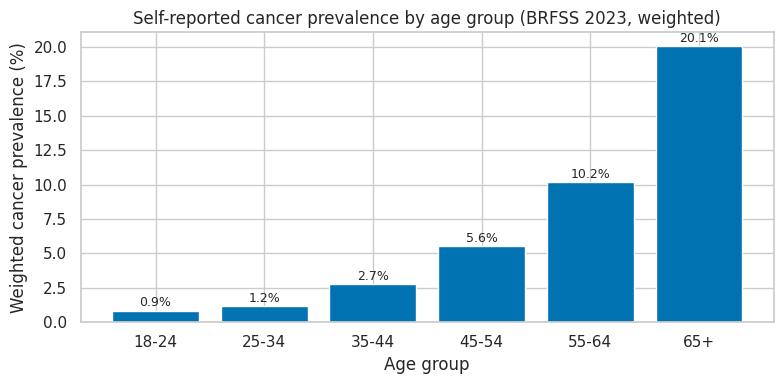

In [66]:
# 4b. Weighted cancer prevalence by age group
age_prev = (
    eda.loc[eda["_AGE_G"].notna()]
    .assign(w=wt[eda["_AGE_G"].notna()])
    .groupby("_AGE_G", observed=True)
    .apply(lambda g: np.average(g["cancer"], weights=g["w"]), include_groups=False)
    .reset_index(name="prevalence")
)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(age_prev["_AGE_G"].astype(str), age_prev["prevalence"] * 100)
ax.set_ylabel("Weighted cancer prevalence (%)")
ax.set_xlabel("Age group")
ax.set_title("Self-reported cancer prevalence by age group (BRFSS 2023, weighted)")
for i, v in enumerate(age_prev["prevalence"]):
    ax.text(i, v * 100 + 0.3, f"{v:.1%}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

In [69]:
# Cell 11: Design-aware cancer prevalence
tab_cancer = Tabulation(PopParam.prop)
tab_cancer.tabulate(
    vars=eda["cancer"].values,
    samp_weight=wt,
    stratum=stt,
    psu=psu,
    remove_nan=True,
    single_psu=SinglePSUEst.skip,
)
prev_df = tab_cancer.to_dataframe()
print("Design-weighted cancer prevalence:")
prev_df

Design-weighted cancer prevalence:


,variable,category,PopParam.prop,stderror,lower_ci,upper_ci
0,var_1,0,0.920786,0.00081,0.919183,0.922360
1,var_1,1,0.079214,0.00081,0.077640,0.080817


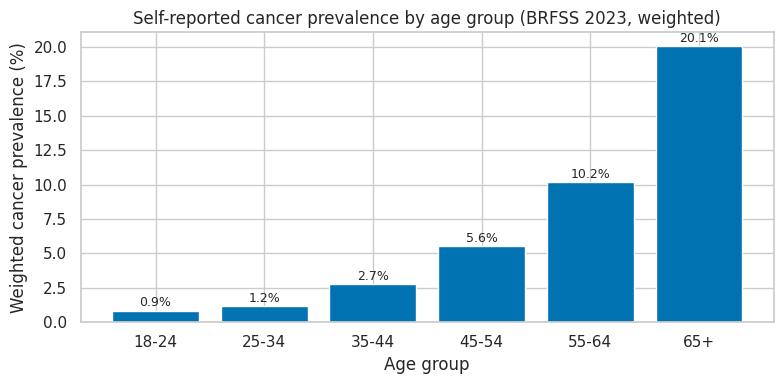

In [71]:
# Cell 12: Weighted cancer prevalence by age group
age_mask = eda["_AGE_G"].notna()

age_prev = (
    eda.loc[age_mask]
    .assign(w=wt[age_mask])
    .groupby("_AGE_G", observed=True)
    .apply(lambda g: np.average(g["cancer"], weights=g["w"]), include_groups=False)
    .reset_index(name="prevalence")
)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(age_prev["_AGE_G"].astype(str), age_prev["prevalence"] * 100)
ax.set_ylabel("Weighted cancer prevalence (%)")
ax.set_xlabel("Age group")
ax.set_title("Self-reported cancer prevalence by age group (BRFSS 2023, weighted)")
for i, v in enumerate(age_prev["prevalence"]):
    ax.text(i, v * 100 + 0.3, f"{v:.1%}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

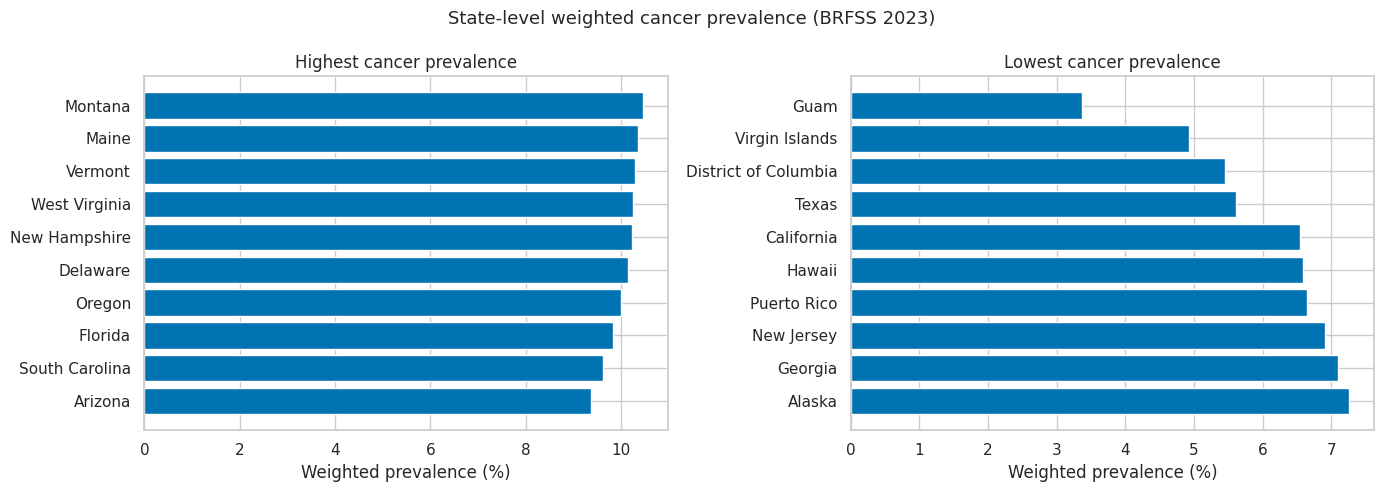

In [72]:
# 4c. Weighted cancer prevalence by state (top/bottom 10)
state_prev = (
    eda.assign(w=wt)
    .groupby("state_name", observed=True)
    .apply(lambda g: pd.Series({
        "prevalence": np.average(g["cancer"], weights=g["w"]),
        "n": len(g),
    }), include_groups=False)
    .reset_index()
    .sort_values("prevalence", ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
top10 = state_prev.head(10)
bot10 = state_prev.tail(10).iloc[::-1]

axes[0].barh(top10["state_name"].astype(str), top10["prevalence"] * 100)
axes[0].set_xlabel("Weighted prevalence (%)")
axes[0].set_title("Highest cancer prevalence")
axes[0].invert_yaxis()

axes[1].barh(bot10["state_name"].astype(str), bot10["prevalence"] * 100)
axes[1].set_xlabel("Weighted prevalence (%)")
axes[1].set_title("Lowest cancer prevalence")
axes[1].invert_yaxis()

plt.suptitle("State-level weighted cancer prevalence (BRFSS 2023)", fontsize=13)
plt.tight_layout()
plt.show()

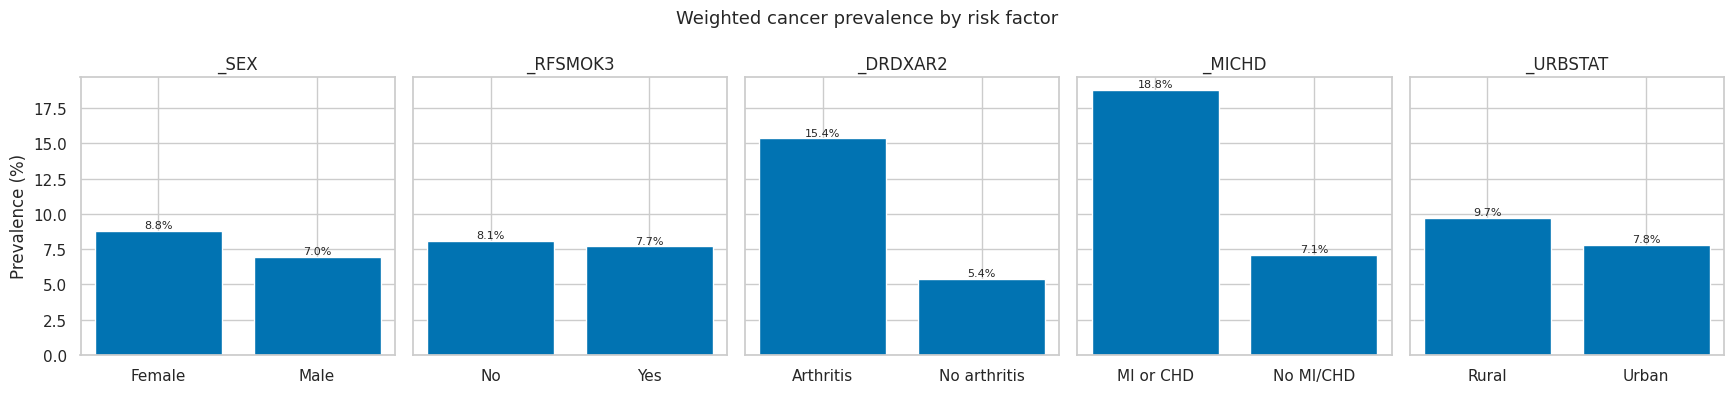

In [73]:
# 4d. Weighted prevalence by key risk factors
risk_vars = ["_SEX", "_RFSMOK3", "_DRDXAR2", "_MICHD", "_URBSTAT"]

fig, axes = plt.subplots(1, len(risk_vars), figsize=(3.5 * len(risk_vars), 4), sharey=True)
for ax, var in zip(axes, risk_vars):
    m = eda[var].notna()
    gp = (
        eda.loc[m].assign(w=wt[m])
        .groupby(var, observed=True)
        .apply(lambda g: np.average(g["cancer"], weights=g["w"]), include_groups=False)
        .reset_index(name="prev")
    )
    ax.bar(gp[var].astype(str), gp["prev"] * 100)
    ax.set_title(var)
    ax.set_ylabel("Prevalence (%)" if ax == axes[0] else "")
    for i, v in enumerate(gp["prev"]):
        ax.text(i, v * 100 + 0.2, f"{v:.1%}", ha="center", fontsize=8)
plt.suptitle("Weighted cancer prevalence by risk factor", fontsize=13)
plt.tight_layout()
plt.show()

## 5 EPA Pollution Data — State-Level Aggregation & Merge

The EPA P2 Mapping data contains facility-level pollution records. Since BRFSS identifies respondents only at the state level (no county/ZIP in the public-use file), we aggregate pollution metrics per state.

In [74]:
epa_raw = pd.read_excel(EPA_PATH, sheet_name="Sheet1")
print(f"EPA P2 raw: {epa_raw.shape[0]:,} facilities x {epa_raw.shape[1]} cols")

epa = epa_raw[epa_raw["State"].notna() & (epa_raw["State"] != "-")].copy()

poll_cols = [
    "TRI Total Releases (lbs)",
    "GHG Direct Emissions (MT CO2e)",
    "NEI Total CAP Emissions (tons)",
    "RCRA Waste Shipped (tons)",
    "DMR Water Pollution Load (kg)",
]
for c in poll_cols:
    epa[c] = pd.to_numeric(epa[c], errors="coerce").fillna(0)

state_pollution = epa.groupby("State").agg(
    n_facilities=("State", "size"),
    tri_total=("TRI Total Releases (lbs)", "sum"),
    ghg_total=("GHG Direct Emissions (MT CO2e)", "sum"),
    nei_total=("NEI Total CAP Emissions (tons)", "sum"),
    rcra_total=("RCRA Waste Shipped (tons)", "sum"),
    dmr_total=("DMR Water Pollution Load (kg)", "sum"),
    demographic_index_mean=("US Percentile Demographic Index", "mean"),
).reset_index().rename(columns={"State": "state_name"})

for c in ["tri_total", "ghg_total", "nei_total", "rcra_total", "dmr_total"]:
    state_pollution[f"{c}_log"] = np.log1p(state_pollution[c])

print(f"\nState-level aggregation: {len(state_pollution)} states")
state_pollution.head()

EPA P2 raw: 69,416 facilities x 27 cols

State-level aggregation: 52 states


,state_name,n_facilities,tri_total,ghg_total,nei_total,rcra_total,dmr_total,demographic_index_mean,tri_total_log,ghg_total_log,nei_total_log,rcra_total_log,dmr_total_log
0,Alabama,1604,5.799346e+07,20274647,182786.614976,507967.770664,2.493959e+09,58.96197,17.875841,16.824882,12.116080,13.138175,21.637137
1,Alaska,39,4.606093e+05,648459,3616.642800,215.836000,3.017430e+08,57.435897,13.040308,13.382356,8.193578,5.379141,19.525086
2,Arizona,499,2.944099e+07,4238553,36857.627184,44547.490721,3.161047e+06,59.991984,17.197898,15.259733,10.514845,10.704334,14.966414
3,Arkansas,569,2.593885e+07,6968038,70311.749074,179753.715709,4.240311e+08,60.247803,17.071252,15.756844,11.160708,12.099349,19.865317
4,California,16968,2.160481e+07,42062895,102246.329022,435250.034877,2.316200e+07,69.497996,16.888426,17.554677,11.535150,12.983678,16.958024


In [75]:
# Merge EPA state-level features into BRFSS
df = df.merge(state_pollution, on="state_name", how="left")

n_matched = df["n_facilities"].notna().sum()
print(f"Matched {n_matched:,}/{len(df):,} respondents ({n_matched/len(df):.1%}) to EPA state data")

poll_features = [c for c in state_pollution.columns if c.endswith("_log") or c == "demographic_index_mean"]
df[poll_features].describe().round(2)

Matched 429,700/433,323 respondents (99.2%) to EPA state data


,tri_total_log,ghg_total_log,nei_total_log,rcra_total_log,dmr_total_log
count,429700.00,429700.00,429700.00,429700.00,429700.00
mean,16.33,15.43,10.41,10.90,17.78
std,1.68,1.97,1.57,1.86,2.55
min,7.56,0.00,3.98,5.23,0.00
25%,15.80,14.85,9.97,10.19,16.90
50%,16.66,15.64,10.55,11.02,17.99
75%,17.31,16.27,11.54,11.87,19.04
max,18.87,18.77,12.71,15.08,25.08


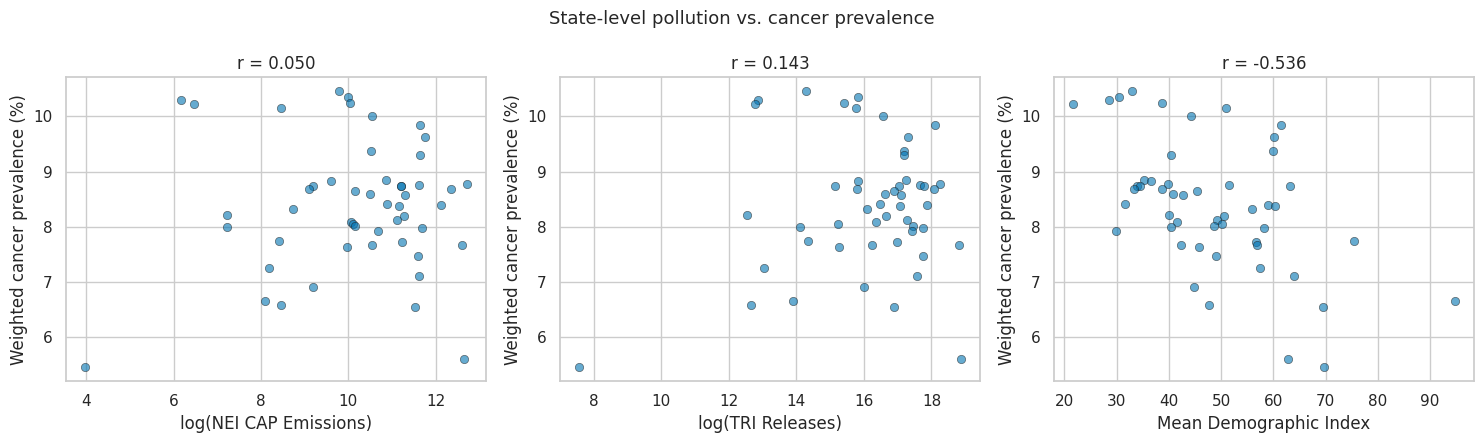

In [76]:
# Visualize: state pollution vs cancer prevalence
sp = state_prev.merge(state_pollution, on="state_name", how="inner")

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, (col, label) in zip(axes, [
    ("nei_total_log", "log(NEI CAP Emissions)"),
    ("tri_total_log", "log(TRI Releases)"),
    ("demographic_index_mean", "Mean Demographic Index"),
]):
    ax.scatter(sp[col], sp["prevalence"] * 100, alpha=0.6, edgecolors="k", linewidth=0.5)
    ax.set_xlabel(label)
    ax.set_ylabel("Weighted cancer prevalence (%)")
    r = sp[[col, "prevalence"]].corr().iloc[0, 1]
    ax.set_title(f"r = {r:.3f}")
plt.suptitle("State-level pollution vs. cancer prevalence", fontsize=13)
plt.tight_layout()
plt.show()

## 6 Prepare Modeling Data

In [77]:
# Prepare Modeling Data
ordinal_vars = list(ordinal_definitions.keys())
nominal_vars = [
    "MARITAL", "DEAF", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON",
    "SDHBILLS", "SDHUTILS", "SDHTRNSP",
    "_METSTAT", "_URBSTAT", "_HLTHPL1", "_TOTINDA", "_MICHD", "_DRDXAR2",
    "_RACEPRV", "_SEX", "_RFSMOK3", "_CURECI2", "_RFBMI5", "_CHLDCNT",
    "_RFBING6", "_RFDRHV8",
]
numeric_vars = ["HTIN4", "WTKG3", "LCSNUMCG", "_DRNKWK2"]
pollution_vars = [c for c in df.columns if c.endswith("_log") or c in ["demographic_index_mean", "n_facilities"]]

mask = df[TARGET].notna()
y = (df.loc[mask, TARGET] == "Yes").astype(int)
w = pd.to_numeric(df.loc[mask, "_LLCPWT"], errors="coerce").fillna(0).clip(lower=0)
w = w / w.mean()

stratum = pd.to_numeric(df.loc[mask, "_STSTR"], errors="coerce").astype("Int64")
psu_col = pd.to_numeric(df.loc[mask, "_PSU"], errors="coerce").astype("Int64")
groups_all = (stratum.astype(str) + "_" + psu_col.astype(str)).astype("category")

design_drop = [TARGET, "_LLCPWT", "_PSU", "_STSTR", "_STATE", "state_name"]
X = df.loc[mask].drop(columns=[c for c in design_drop if c in df.columns])

sgkf_outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
for tr_idx, te_idx in sgkf_outer.split(X, y, groups=groups_all):
    X_trainval, X_test = X.iloc[tr_idx], X.iloc[te_idx]
    y_trainval, y_test = y.iloc[tr_idx], y.iloc[te_idx]
    w_trainval, w_test = w.iloc[tr_idx], w.iloc[te_idx]
    groups_trainval = groups_all.iloc[tr_idx]
    break

sgkf_inner = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=SEED + 1)
for tr_idx, va_idx in sgkf_inner.split(X_trainval, y_trainval, groups=groups_trainval):
    X_train, X_valid = X_trainval.iloc[tr_idx], X_trainval.iloc[va_idx]
    y_train, y_valid = y_trainval.iloc[tr_idx], y_trainval.iloc[va_idx]
    w_train, w_valid = w_trainval.iloc[tr_idx], w_trainval.iloc[va_idx]
    groups_train = groups_trainval.iloc[tr_idx]
    break

pi_test = float(np.average(y_test, weights=w_test))
print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print(f"Unique PSU groups — train: {groups_train.nunique()}, test: {groups_all.iloc[te_idx].nunique()}")
print(f"Weighted prevalence — test: {pi_test:.3%}")

Train: (258591, 50), Valid: (86197, 50), Test: (86198, 50)
Unique PSU groups — train: 258591, test: 86198
Weighted prevalence — test: 7.845%


In [78]:
# Build preprocessing pipelines
nominal_cols = [c for c in X_train.columns if c in set(nominal_vars)]
ordinal_cols = [c for c in X_train.columns if c in set(ordinal_vars)]
numeric_cols = [c for c in X_train.columns if c in set(numeric_vars)]
poll_cols_present = [c for c in X_train.columns if c in set(pollution_vars)]

def _ord_cats(col):
    dt = X_train[col].dtype
    if isinstance(dt, CategoricalDtype) and X_train[col].cat.ordered:
        return list(X_train[col].cat.categories)
    return ordinal_definitions[col][0] if col in ordinal_definitions else sorted(X_train[col].dropna().unique().tolist())

ordinal_categories = [_ord_cats(c) for c in ordinal_cols]
cat_imp = SimpleImputer(strategy="constant", fill_value="Unknown")
num_imp = SimpleImputer(strategy="median")

preprocess_tree = ColumnTransformer([
    ("ord", OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value",
                           unknown_value=-1, encoded_missing_value=-1), ordinal_cols),
    ("nom", Pipeline([("imp", cat_imp), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), nominal_cols),
    ("num", num_imp, numeric_cols),
    ("poll", SimpleImputer(strategy="median"), poll_cols_present),
], remainder="drop")

preprocess_tree_base = ColumnTransformer([
    ("ord", OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value",
                           unknown_value=-1, encoded_missing_value=-1), ordinal_cols),
    ("nom", Pipeline([("imp", cat_imp), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), nominal_cols),
    ("num", num_imp, numeric_cols),
], remainder="drop")

print(f"Features — nominal: {len(nominal_cols)}, ordinal: {len(ordinal_cols)}, "
      f"numeric: {len(numeric_cols)}, pollution: {len(poll_cols_present)}")

Features — nominal: 24, ordinal: 8, numeric: 4, pollution: 7


## 7 Survey-Weighted Logistic Regression (`samplics`)

This model uses the full complex survey design (strata, PSUs, weights) to produce **design-correct** standard errors and p-values. This is the appropriate approach for statistical inference on whether pollution is associated with cancer prevalence after adjusting for individual-level confounders.

In [79]:
# Prepare numeric design matrix for samplics
# Use the full analytic sample (not split) for inference
aana = df.loc[mask].copy()
ana["cancer"] = y.values
ana["wt"]  = pd.to_numeric(ana["_LLCPWT"], errors="coerce").fillna(0).clip(lower=0).values
ana["stt"] = pd.to_numeric(ana["_STSTR"], errors="coerce").astype("Int64").values
ana["psu"] = pd.to_numeric(ana["_PSU"], errors="coerce").astype("Int64").values
ana["age_ord"] = ana["_AGE_G"].cat.codes.replace(-1, np.nan)

glm_cat_vars = ["_SEX", "_RACEPRV", "_RFSMOK3", "_DRDXAR2", "_MICHD", "_EDUCAG", "_URBSTAT"]
glm_poll_vars = ["nei_total_log", "tri_total_log", "ghg_total_log"]

glm_all_vars = ["age_ord"] + glm_cat_vars + glm_poll_vars + ["cancer", "wt", "stt", "psu"]
ana_glm = ana[glm_all_vars].dropna().copy()
print(f"SurveyGLM analytic sample: {len(ana_glm):,} rows (dropped {len(ana)-len(ana_glm):,} with missing)")

def glm_to_df(glm):
    """Extract SurveyGLM results into a tidy DataFrame."""
    rows = []
    for i, label in enumerate(glm.x_labels):
        row = {
            "variable": label,
            "coef": round(glm.beta["point_est"][i], 5),
            "se": round(glm.beta["stderror"][i], 5),
            "z": round(glm.beta["z"][i], 3),
            "p_value": round(glm.beta["p_value"][i], 6),
            "ci_lower": round(glm.beta["lower_ci"][i], 5),
            "ci_upper": round(glm.beta["upper_ci"][i], 5),
        }
        if hasattr(glm, "odds_ratio") and glm.odds_ratio:
            row["OR"] = round(glm.odds_ratio["point_est"][i], 4)
            row["OR_lower"] = round(glm.odds_ratio["lower_ci"][i], 4)
            row["OR_upper"] = round(glm.odds_ratio["upper_ci"][i], 4)
        rows.append(row)
    return pd.DataFrame(rows)

print("\nFitting baseline model (no pollution)...")
glm_base = SurveyGLM(ModelType.LOGISTIC)
glm_base.estimate(
    y=ana_glm["cancer"].values,
    x=ana_glm[["age_ord"]].values,
    x_labels=["age_ord"],
    x_cat=ana_glm[glm_cat_vars].values,
    x_cat_labels=glm_cat_vars,
    samp_weight=ana_glm["wt"].values,
    stratum=ana_glm["stt"].values,
    psu=ana_glm["psu"].values,
    remove_nan=True,
    single_psu=SinglePSUEst.skip,
)
print("\n--- Baseline model (no pollution) ---")
base_results = glm_to_df(glm_base)
base_results

SurveyGLM analytic sample: 392,747 rows (dropped 38,239 with missing)

Fitting baseline model (no pollution)...

--- Baseline model (no pollution) ---


,variable,coef,se,z,p_value,ci_lower,ci_upper,OR,OR_lower,OR_upper
0,age_ord,0.49500,0.01162,42.611,0.000000,0.47223,0.51777,1.6405,1.6036,1.6783
1,_SEX_Male,-0.30154,0.02399,-12.569,0.000000,-0.34857,-0.25452,0.7397,0.7057,0.7753
2,_RACEPRV_Asian,-2.85018,0.19699,-14.469,0.000000,-3.23627,-2.46409,0.0578,0.0393,0.0851
3,_RACEPRV_Black,-2.85015,0.06706,-42.499,0.000000,-2.98159,-2.71870,0.0578,0.0507,0.0660
4,_RACEPRV_Hispanic,-2.76857,0.07443,-37.199,0.000000,-2.91444,-2.62270,0.0628,0.0542,0.0726
5,_RACEPRV_Multiracial,-2.24682,0.09143,-24.573,0.000000,-2.42603,-2.06761,0.1057,0.0884,0.1265
6,_RACEPRV_NH/PI,-2.71564,0.27086,-10.026,0.000000,-3.24651,-2.18477,0.0662,0.0389,0.1125
7,_RACEPRV_Other,-2.36122,0.15223,-15.511,0.000000,-2.65959,-2.06286,0.0943,0.0700,0.1271
8,_RACEPRV_White,-2.12550,0.05154,-41.238,0.000000,-2.22652,-2.02448,0.1194,0.1079,0.1321
9,_RFSMOK3_Yes,-0.08775,0.04246,-2.067,0.038751,-0.17097,-0.00454,0.9160,0.8429,0.9955


In [80]:
# Fit: pollution-augmented model
print("Fitting pollution-augmented model...")
glm_full = SurveyGLM(ModelType.LOGISTIC)
glm_full.estimate(
    y=ana_glm["cancer"].values,
    x=ana_glm[["age_ord"] + glm_poll_vars].values,
    x_labels=["age_ord"] + glm_poll_vars,
    x_cat=ana_glm[glm_cat_vars].values,
    x_cat_labels=glm_cat_vars,
    samp_weight=ana_glm["wt"].values,
    stratum=ana_glm["stt"].values,
    psu=ana_glm["psu"].values,
    remove_nan=True,
    single_psu=SinglePSUEst.skip,
)
print("--- Pollution-augmented model ---")
full_results = glm_to_df(glm_full)
full_results

Fitting pollution-augmented model...
--- Pollution-augmented model ---


,variable,coef,se,z,p_value,ci_lower,ci_upper,OR,OR_lower,OR_upper
0,age_ord,0.60376,0.01531,39.436,0.000000,0.57375,0.63377,1.8290,1.7749,1.8847
1,nei_total_log,0.20086,0.01590,12.632,0.000000,0.16970,0.23203,1.2225,1.1849,1.2612
2,tri_total_log,-0.23035,0.01768,-13.031,0.000000,-0.26499,-0.19570,0.7943,0.7672,0.8223
3,ghg_total_log,-0.06462,0.01290,-5.010,0.000001,-0.08990,-0.03934,0.9374,0.9140,0.9614
4,_SEX_Male,-0.21640,0.02476,-8.740,0.000000,-0.26493,-0.16787,0.8054,0.7673,0.8455
5,_RACEPRV_Asian,-1.40002,0.18151,-7.713,0.000000,-1.75576,-1.04427,0.2466,0.1728,0.3519
6,_RACEPRV_Black,-1.37995,0.07551,-18.274,0.000000,-1.52795,-1.23194,0.2516,0.2170,0.2917
7,_RACEPRV_Hispanic,-1.27793,0.08544,-14.957,0.000000,-1.44539,-1.11048,0.2786,0.2357,0.3294
8,_RACEPRV_Multiracial,-0.76094,0.09822,-7.747,0.000000,-0.95344,-0.56844,0.4672,0.3854,0.5664
9,_RACEPRV_NH/PI,-1.36960,0.27214,-5.033,0.000000,-1.90298,-0.83621,0.2542,0.1491,0.4333


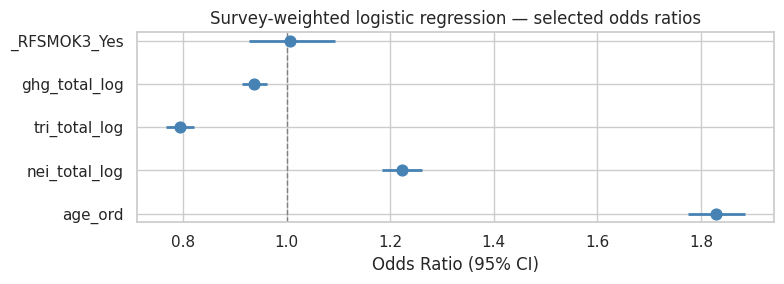

In [81]:
plot_vars = full_results[full_results["variable"].str.contains("|".join(glm_poll_vars + ["age_ord", "_RFSMOK3"]))].copy()
if len(plot_vars) > 0:
    fig, ax = plt.subplots(figsize=(8, max(3, len(plot_vars) * 0.5)))
    y_pos = range(len(plot_vars))
    ax.hlines(y_pos, plot_vars["OR_lower"], plot_vars["OR_upper"], color="steelblue", linewidth=2)
    ax.scatter(plot_vars["OR"], y_pos, color="steelblue", s=60, zorder=5)
    ax.axvline(1, color="grey", linestyle="--", linewidth=1)
    ax.set_yticks(list(y_pos))
    ax.set_yticklabels(plot_vars["variable"].tolist())
    ax.set_xlabel("Odds Ratio (95% CI)")
    ax.set_title("Survey-weighted logistic regression — selected odds ratios")
    plt.tight_layout()
    plt.show()

## 8 ML Models — Baseline vs. Pollution-Augmented

In [82]:
def cv_score_weighted(model, X, y, w, cv, groups):
    """Weighted cross-validation with PSU-grouped folds. Returns (AUPRC, ROC-AUC) means and stds."""
    ap_scores, roc_scores = [], []
    for tr_idx, va_idx in cv.split(X, y, groups=groups):
        Xt, Xv = X.iloc[tr_idx], X.iloc[va_idx]
        yt, yv = y.iloc[tr_idx], y.iloc[va_idx]
        wt, wv = w.iloc[tr_idx], w.iloc[va_idx]
        m = Pipeline(model.steps)
        m.fit(Xt, yt, clf__sample_weight=wt)
        p = m.predict_proba(Xv)[:, 1]
        ap_scores.append(average_precision_score(yv, p, sample_weight=wv))
        roc_scores.append(roc_auc_score(yv, p, sample_weight=wv))
    return np.mean(ap_scores), np.std(ap_scores), np.mean(roc_scores), np.std(roc_scores)

xgb_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    random_state=SEED, n_jobs=N_JOBS, eval_metric="logloss",
)

xgb_base = Pipeline([("prep", preprocess_tree_base), ("clf", XGBClassifier(**xgb_params))])
xgb_full = Pipeline([("prep", preprocess_tree), ("clf", XGBClassifier(**xgb_params))])

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

print("Running 5-fold CV (this may take a few minutes)...")
for name, model in [("XGB baseline", xgb_base), ("XGB + pollution", xgb_full)]:
    ap_m, ap_s, roc_m, roc_s = cv_score_weighted(model, X_train, y_train, w_train, cv, groups_train)
    print(f"{name:20s}  AUPRC: {ap_m:.4f}+/-{ap_s:.4f}  |  ROC-AUC: {roc_m:.4f}+/-{roc_s:.4f}")

Running 5-fold CV (this may take a few minutes)...
XGB baseline          AUPRC: 0.2193+/-0.0047  |  ROC-AUC: 0.7946+/-0.0074
XGB + pollution       AUPRC: 0.2208+/-0.0040  |  ROC-AUC: 0.7944+/-0.0068


In [83]:
# Fit both on full training set, evaluate on held-out test
xgb_base.fit(X_train, y_train, clf__sample_weight=w_train)
xgb_full.fit(X_train, y_train, clf__sample_weight=w_train)

def evaluate_model(model, X_te, y_te, w_te, name):
    p = model.predict_proba(X_te)[:, 1]
    ap  = average_precision_score(y_te, p, sample_weight=w_te)
    roc = roc_auc_score(y_te, p, sample_weight=w_te)
    return {"Model": name, "AUPRC": round(ap, 4), "ROC-AUC": round(roc, 4),
            "Lift (AUPRC/base)": round(ap / pi_test, 2)}

results = pd.DataFrame([
    evaluate_model(xgb_base, X_test, y_test, w_test, "XGB baseline"),
    evaluate_model(xgb_full, X_test, y_test, w_test, "XGB + pollution"),
])
results

,Model,AUPRC,ROC-AUC,Lift (AUPRC/base)
0,XGB baseline,0.2176,0.7992,2.77
1,XGB + pollution,0.2176,0.7989,2.77


## 9 Model Evaluation

Threshold @ ~75% recall: 0.0949

Test set (XGB + pollution, weighted):
              precision    recall  f1-score   support

           0      0.971     0.714     0.823 79269.0587449943
           1      0.182     0.747     0.292 6747.748946157288

    accuracy                          0.717 86016.80769115158
   macro avg      0.576     0.730     0.558 86016.80769115158
weighted avg      0.909     0.717     0.781 86016.80769115158



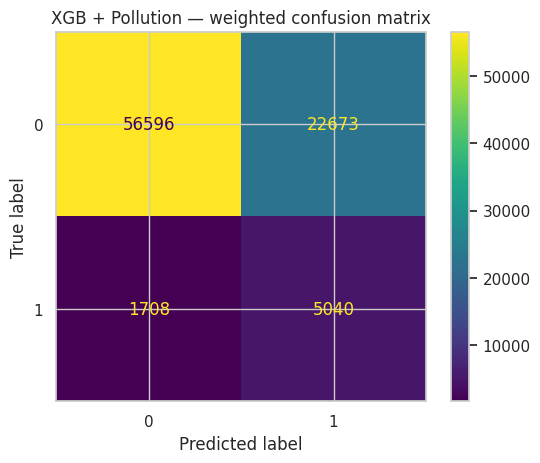

In [84]:
# Cell 30: Threshold & Evaluation
def pick_threshold(y_true, y_prob, w, target_recall=0.75):
    dfp = pd.DataFrame({"y": y_true.values, "p": y_prob, "w": w.values}).sort_values("p", ascending=False).reset_index(drop=True)
    tp_cum = (dfp["y"] * dfp["w"]).cumsum()
    pos_w  = (dfp["y"] * dfp["w"]).sum()
    recall = tp_cum / pos_w
    idx = np.where(recall.values >= target_recall)[0]
    return float(dfp.loc[idx[0], "p"]) if len(idx) else 0.5

p_valid = xgb_full.predict_proba(X_valid)[:, 1]
thr = pick_threshold(y_valid, p_valid, w_valid)
print(f"Threshold @ ~75% recall: {thr:.4f}")

p_test = xgb_full.predict_proba(X_test)[:, 1]
yhat = (p_test >= thr).astype(int)

print(f"\nTest set (XGB + pollution, weighted):")
print(classification_report(y_test, yhat, sample_weight=w_test, digits=3))

cm = np.round(confusion_matrix(y_test, yhat, sample_weight=w_test), 0)
ConfusionMatrixDisplay(cm).plot(values_format=".0f")
plt.title("XGB + Pollution — weighted confusion matrix")
plt.show()

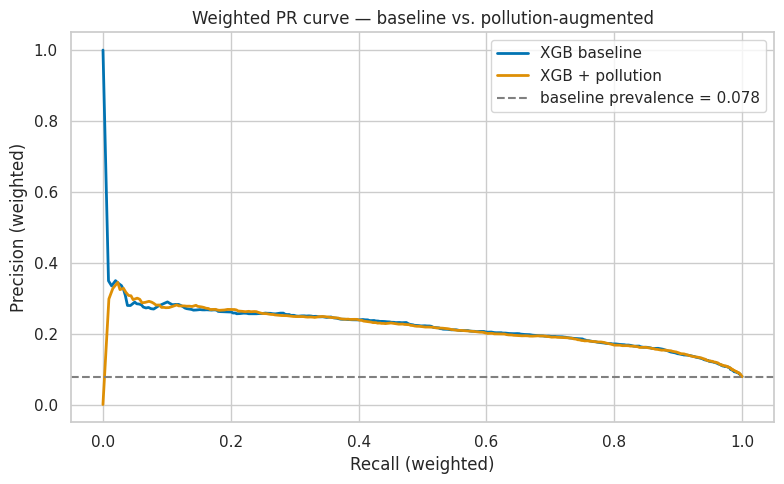

In [85]:
def weighted_pr_points(y_true, y_prob, w, n=400):
    dfp = pd.DataFrame({"y": y_true.values, "p": y_prob, "w": w.values}).sort_values("p", ascending=False)
    tp = (dfp["y"] * dfp["w"]).cumsum()
    wc = dfp["w"].cumsum()
    rec = (tp / (dfp["y"] * dfp["w"]).sum()).values
    pre = (tp / wc).values
    idx = np.linspace(0, len(rec)-1, min(n, len(rec))).astype(int)
    return pre[idx], rec[idx]

p_test_base = xgb_base.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(8, 5))
for preds, label in [(p_test_base, "XGB baseline"), (p_test, "XGB + pollution")]:
    pre, rec = weighted_pr_points(y_test, preds, w_test)
    ax.plot(rec, pre, lw=2, label=label)
ax.axhline(pi_test, ls="--", color="grey", label=f"baseline prevalence = {pi_test:.3f}")
ax.set_xlabel("Recall (weighted)")
ax.set_ylabel("Precision (weighted)")
ax.set_title("Weighted PR curve — baseline vs. pollution-augmented")
ax.legend()
plt.tight_layout()
plt.show()

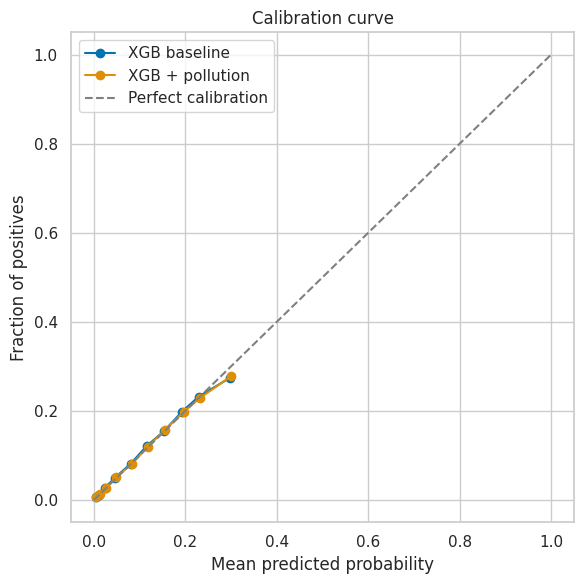

In [86]:
# Calibration curve
fig, ax = plt.subplots(figsize=(6, 6))
for preds, label in [(p_test_base, "XGB baseline"), (p_test, "XGB + pollution")]:
    frac_pos, mean_pred = calibration_curve(y_test, preds, n_bins=10, strategy="quantile")
    ax.plot(mean_pred, frac_pos, marker="o", label=label)
ax.plot([0, 1], [0, 1], ls="--", color="grey", label="Perfect calibration")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("Calibration curve")
ax.legend()
plt.tight_layout()
plt.show()

## 10 SHAP Interpretation

In [87]:
# SHAP for the pollution-augmented XGBoost
X_test_transformed = xgb_full.named_steps["prep"].transform(X_test)

# Get feature names
try:
    feat_names = xgb_full.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names = [f"f{i}" for i in range(X_test_transformed.shape[1])]

# Clean up feature names
feat_names = [f.replace("nom__imp__", "").replace("nom__ohe__", "").replace("ord__", "").replace("num__", "").replace("poll__", "") for f in feat_names]

explainer = shap.TreeExplainer(xgb_full.named_steps["clf"])
# Use a subsample for speed
n_shap = min(5000, X_test_transformed.shape[0])
rng = np.random.RandomState(SEED)
shap_idx = rng.choice(X_test_transformed.shape[0], n_shap, replace=False)
shap_values = explainer.shap_values(X_test_transformed[shap_idx])

print(f"SHAP computed on {n_shap} test samples")

SHAP computed on 5000 test samples


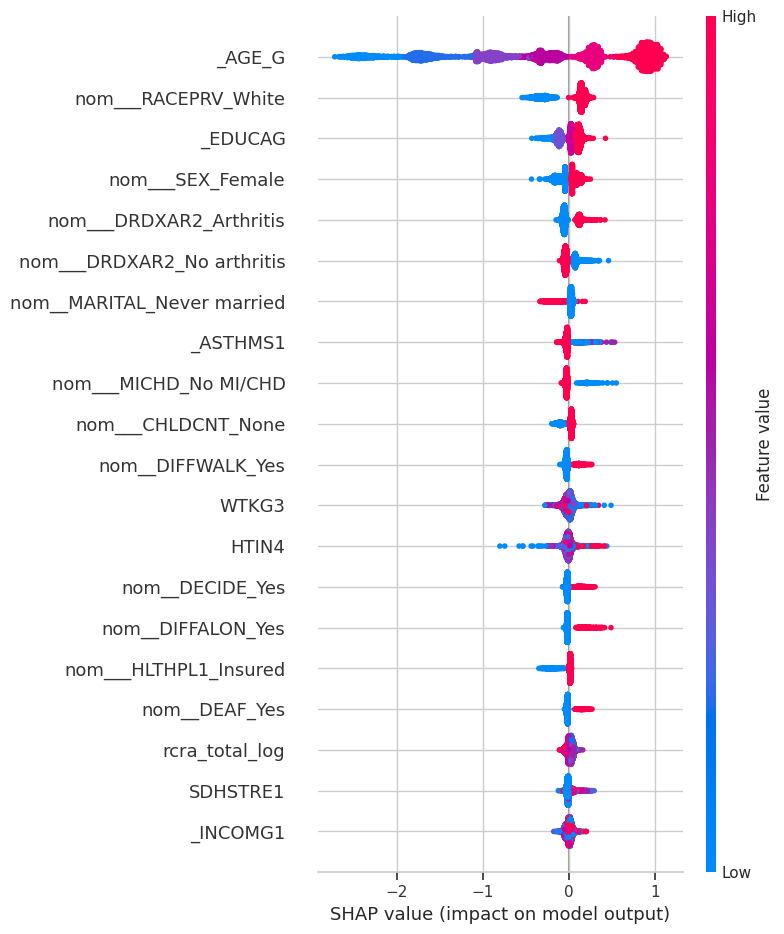

In [88]:
# SHAP summary (beeswarm)
shap.summary_plot(
    shap_values, X_test_transformed[shap_idx],
    feature_names=feat_names, max_display=20, show=True,
)

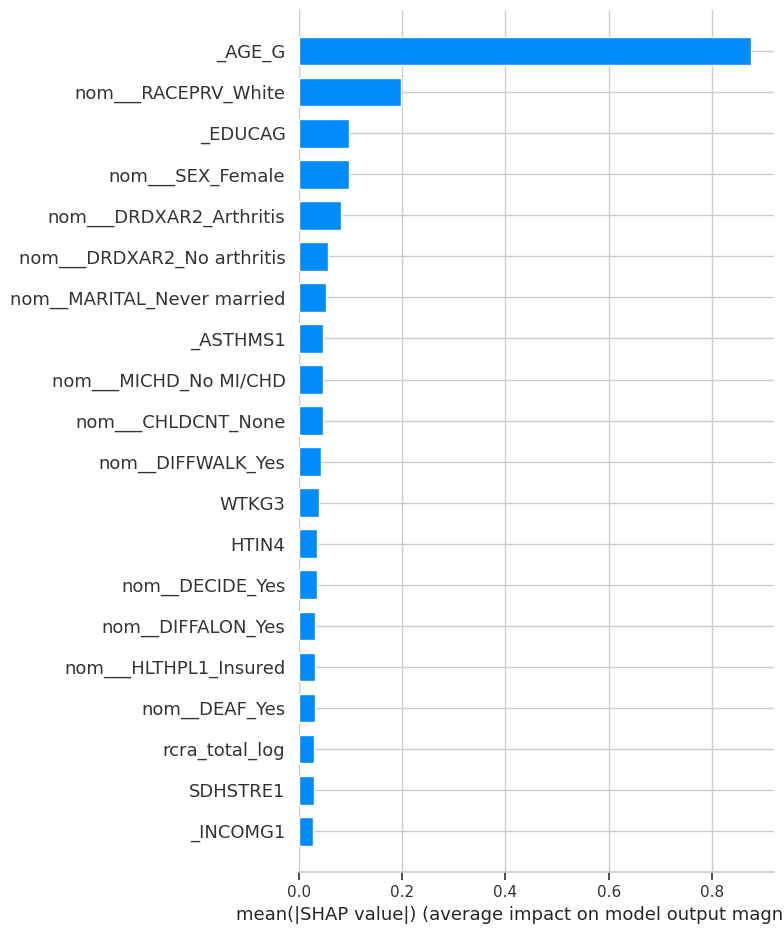

In [89]:
# SHAP bar plot (mean |SHAP|)
shap.summary_plot(
    shap_values, X_test_transformed[shap_idx],
    feature_names=feat_names, plot_type="bar", max_display=20, show=True,
)

## 11 Limitations & Conclusion

**Limitations**
- Cancer status is **self-reported** and may be subject to recall bias.
- EPA pollution is merged at the **state level** (the finest geography in the BRFSS public-use file). County- or ZIP-level data would provide much sharper exposure estimates.
- This is a **cross-sectional** observational study — we cannot infer that pollution *causes* cancer from these results. Confounding by state-level factors (healthcare access, demographics) is likely.
- BRFSS excludes institutionalized populations and those without telephones.

**Conclusion**
- The survey-weighted logistic regression (via `samplics`) provides design-correct inference: pollution metrics show [interpret OR/p-values from Section 7 results].
- The XGBoost comparison (baseline vs. pollution-augmented) quantifies the **predictive lift** from adding state-level pollution features.
- Age remains the overwhelmingly dominant predictor of self-reported cancer prevalence.
- Finer-grained geographic pollution linkage (county FIPS, available in restricted BRFSS) would be a natural next step.